In [30]:
from astrodendro import Dendrogram
# d = Dendrogram.compute(array)

In [31]:
# General Imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Astronomy Specific Imports
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits

# Image Analysis Specific Imports
from skimage.measure import perimeter, euler_number

import porespy as ps
ps.visualization.set_mpl_style()

def remove_region(data, wcs, longitude_min, longitude_max, latitude_min, latitude_max):
    
    min_coord_remove = SkyCoord(longitude_min, latitude_min, frame='galactic', unit=u.deg)
    max_coord_remove = SkyCoord(longitude_max, latitude_max, frame='galactic', unit=u.deg)

    min_pixel_remove = wcs[:][:][0].world_to_pixel(min_coord_remove)
    max_pixel_remove = wcs[:][:][0].world_to_pixel(max_coord_remove)

    # Create a mask based on these galactic coordinates
    remove_mask = np.zeros(data.shape, dtype=bool)

    # Set True in the mask for the specified region based on pixel indices
    y_min, x_min = int(np.floor(min_pixel_remove[1])), int(np.floor(min_pixel_remove[0]))
    y_max, x_max = int(np.ceil(max_pixel_remove[1])), int(np.ceil(max_pixel_remove[0]))

    # Apply the mask to the region within the pixel boundaries
    remove_mask[y_min:y_max, x_max:x_min] = True
    
    # Apply the mask to the original data to set the region to NaN or another value
    data[remove_mask] = np.nan  # Replace with np.nan to exclude the data

    return data

def derive_density_maps():
    # Get the current working directory
    curr_folder = os.getcwd()

    # Find the index of 'notebooks' in the current path
    notebooks_index = curr_folder.rfind('notebooks')

    # Check if 'notebooks' is found in the path
    if notebooks_index != -1:
        # Set the directory to the parent of 'notebooks'
        src_path = os.path.dirname(curr_folder[:notebooks_index])
        os.chdir(src_path)  # Change the current working directory to the source path
        sys.path.insert(0, src_path)  # Insert the source path into sys.path for module imports

    # Construct the path to the FITS file
    planck_herschel_fits_file = os.path.join(curr_folder, "Lombardi", "planck_herschel.fits.gz")

    hdu_herschel_fits = fits.open(planck_herschel_fits_file)[0]
    
    # Constructt WCS and image data
    wcs = WCS(hdu_herschel_fits.header)

    image_data = hdu_herschel_fits.data[0]

    # Replace NaNs and Infs with some valid value, e.g., zero or the median
    tau = np.nan_to_num(image_data, nan=0.0, posinf=0.0, neginf=0.0)

    # Step 1: Define constants
    # TO-DO: differentiate between Orion A and B 

    # Orion A: 206 ≤ l ≤ 217, −21 ≤ b ≤ −17
    # Orion B: 203 ≤ l ≤ 210, −17 ≤ b ≤ −12

    # Step 3: Apply the formula to calculate A_k (Lomabrdi et al)
    l_min_A, l_max_A = 206, 217
    b_min_A, b_max_A = -21, -17

    # Making it smaller cause of computation time
    # l_min_A, l_max_A = 210, 212
    # b_min_A, b_max_A = -21, -20

    min_coord_A = SkyCoord(l_min_A, b_min_A, frame='galactic', unit=u.deg)
    max_coord_A = SkyCoord(l_max_A, b_max_A, frame='galactic', unit=u.deg)

    min_pixel_A = wcs[:][:][0].world_to_pixel(min_coord_A)
    max_pixel_A = wcs[:][:][0].world_to_pixel(max_coord_A)

    gamma_orion_A = 2640  # mag
    delta_orion_A = 0.012  # mag, Offset for Orion A

    A_k = gamma_orion_A * tau + delta_orion_A

    A_k[int(min_pixel_A[1]): int(max_pixel_A[1]), int(max_pixel_A[0]): int(min_pixel_A[0])] = gamma_orion_A * tau[int(min_pixel_A[1]): int(max_pixel_A[1]), int(max_pixel_A[0]): int(min_pixel_A[0])] + delta_orion_A

    l_min_B, l_max_B = 203, 210
    b_min_B, b_max_B = -17, -12

    min_coord_B = SkyCoord(l_min_B, b_min_B, frame='galactic', unit=u.deg)
    max_coord_B = SkyCoord(l_max_B, b_max_B, frame='galactic', unit=u.deg)

    min_pixel_B = wcs[:][:][0].world_to_pixel(min_coord_B)
    max_pixel_B = wcs[:][:][0].world_to_pixel(max_coord_B)

    gamma_orion_B = 3460  # mag
    delta_orion_B = -0.001  # mag, Offset for Orion B

    A_k[int(min_pixel_B[1]): int(max_pixel_B[1]), int(max_pixel_B[0]): int(min_pixel_B[0])] = gamma_orion_B * tau[int(min_pixel_B[1]): int(max_pixel_B[1]), int(max_pixel_B[0]): int(min_pixel_B[0])] + delta_orion_B

    # A_k to A_V
    A_V = A_k/0.112

    # N(H2)
    N_H2 = 0.93e21 * np.array(A_V , dtype=np.float64)

    # Define regions to remove as a list of dictionaries
    regions_to_remove = [
        # Orion A regions
        {"longitude_min": 208, "longitude_max": 211, "latitude_min": -17.9, "latitude_max": -16.9},
        {"longitude_min": 214.5, "longitude_max": 216.5, "latitude_min": -18, "latitude_max": -17},
        {"longitude_min": 206, "longitude_max": 206.5, "latitude_min": -19.5, "latitude_max": -19},

        # Orion B regions
        {"longitude_min": 208, "longitude_max": 210, "latitude_min": -15, "latitude_max": -12},
        {"longitude_min": 209, "longitude_max": 210, "latitude_min": -16.4, "latitude_max": -15.5},
        {"longitude_min": 203, "longitude_max": 205, "latitude_min": -12.3, "latitude_max": -11.5},
        {"longitude_min": 204.5, "longitude_max": 205.5, "latitude_min": -12.2, "latitude_max": -11.5},
        {"longitude_min": 205.8, "longitude_max": 207, "latitude_min": -13.5, "latitude_max": -12.5},
    ]

    # Loop through each region and remove it from N_H2
    for region in regions_to_remove:
        N_H2 = remove_region(
            N_H2,
            wcs,
            region["longitude_min"],
            region["longitude_max"],
            region["latitude_min"],
            region["latitude_max"]
        )

    
    N_H2_OA = N_H2[int(min_pixel_A[1]): int(max_pixel_A[1]), int(max_pixel_A[0]): int(min_pixel_A[0])]
    N_H2_OB = N_H2[int(min_pixel_B[1]): int(max_pixel_B[1]), int(max_pixel_B[0]): int(min_pixel_B[0])]

    N_H2 = np.nan_to_num(N_H2, nan=0.0, posinf=0.0, neginf=0.0)
    N_H2_OA = np.nan_to_num(N_H2_OA, nan=0.0, posinf=0.0, neginf=0.0)
    N_H2_OB = np.nan_to_num(N_H2_OB, nan=0.0, posinf=0.0, neginf=0.0)
    
    return N_H2, N_H2_OA, N_H2_OB, wcs

    # Kolmogorov turbulence predicts 
    # D = 5/3 (1.7) for turbulent isobar models
    # D = 4/3 (1.3) for turbulent isothermal models

N_H2, N_H2_OA, N_H2_OB, wcs = derive_density_maps()

KeyboardInterrupt: 

In [5]:
d = Dendrogram.compute(N_H2_OA)

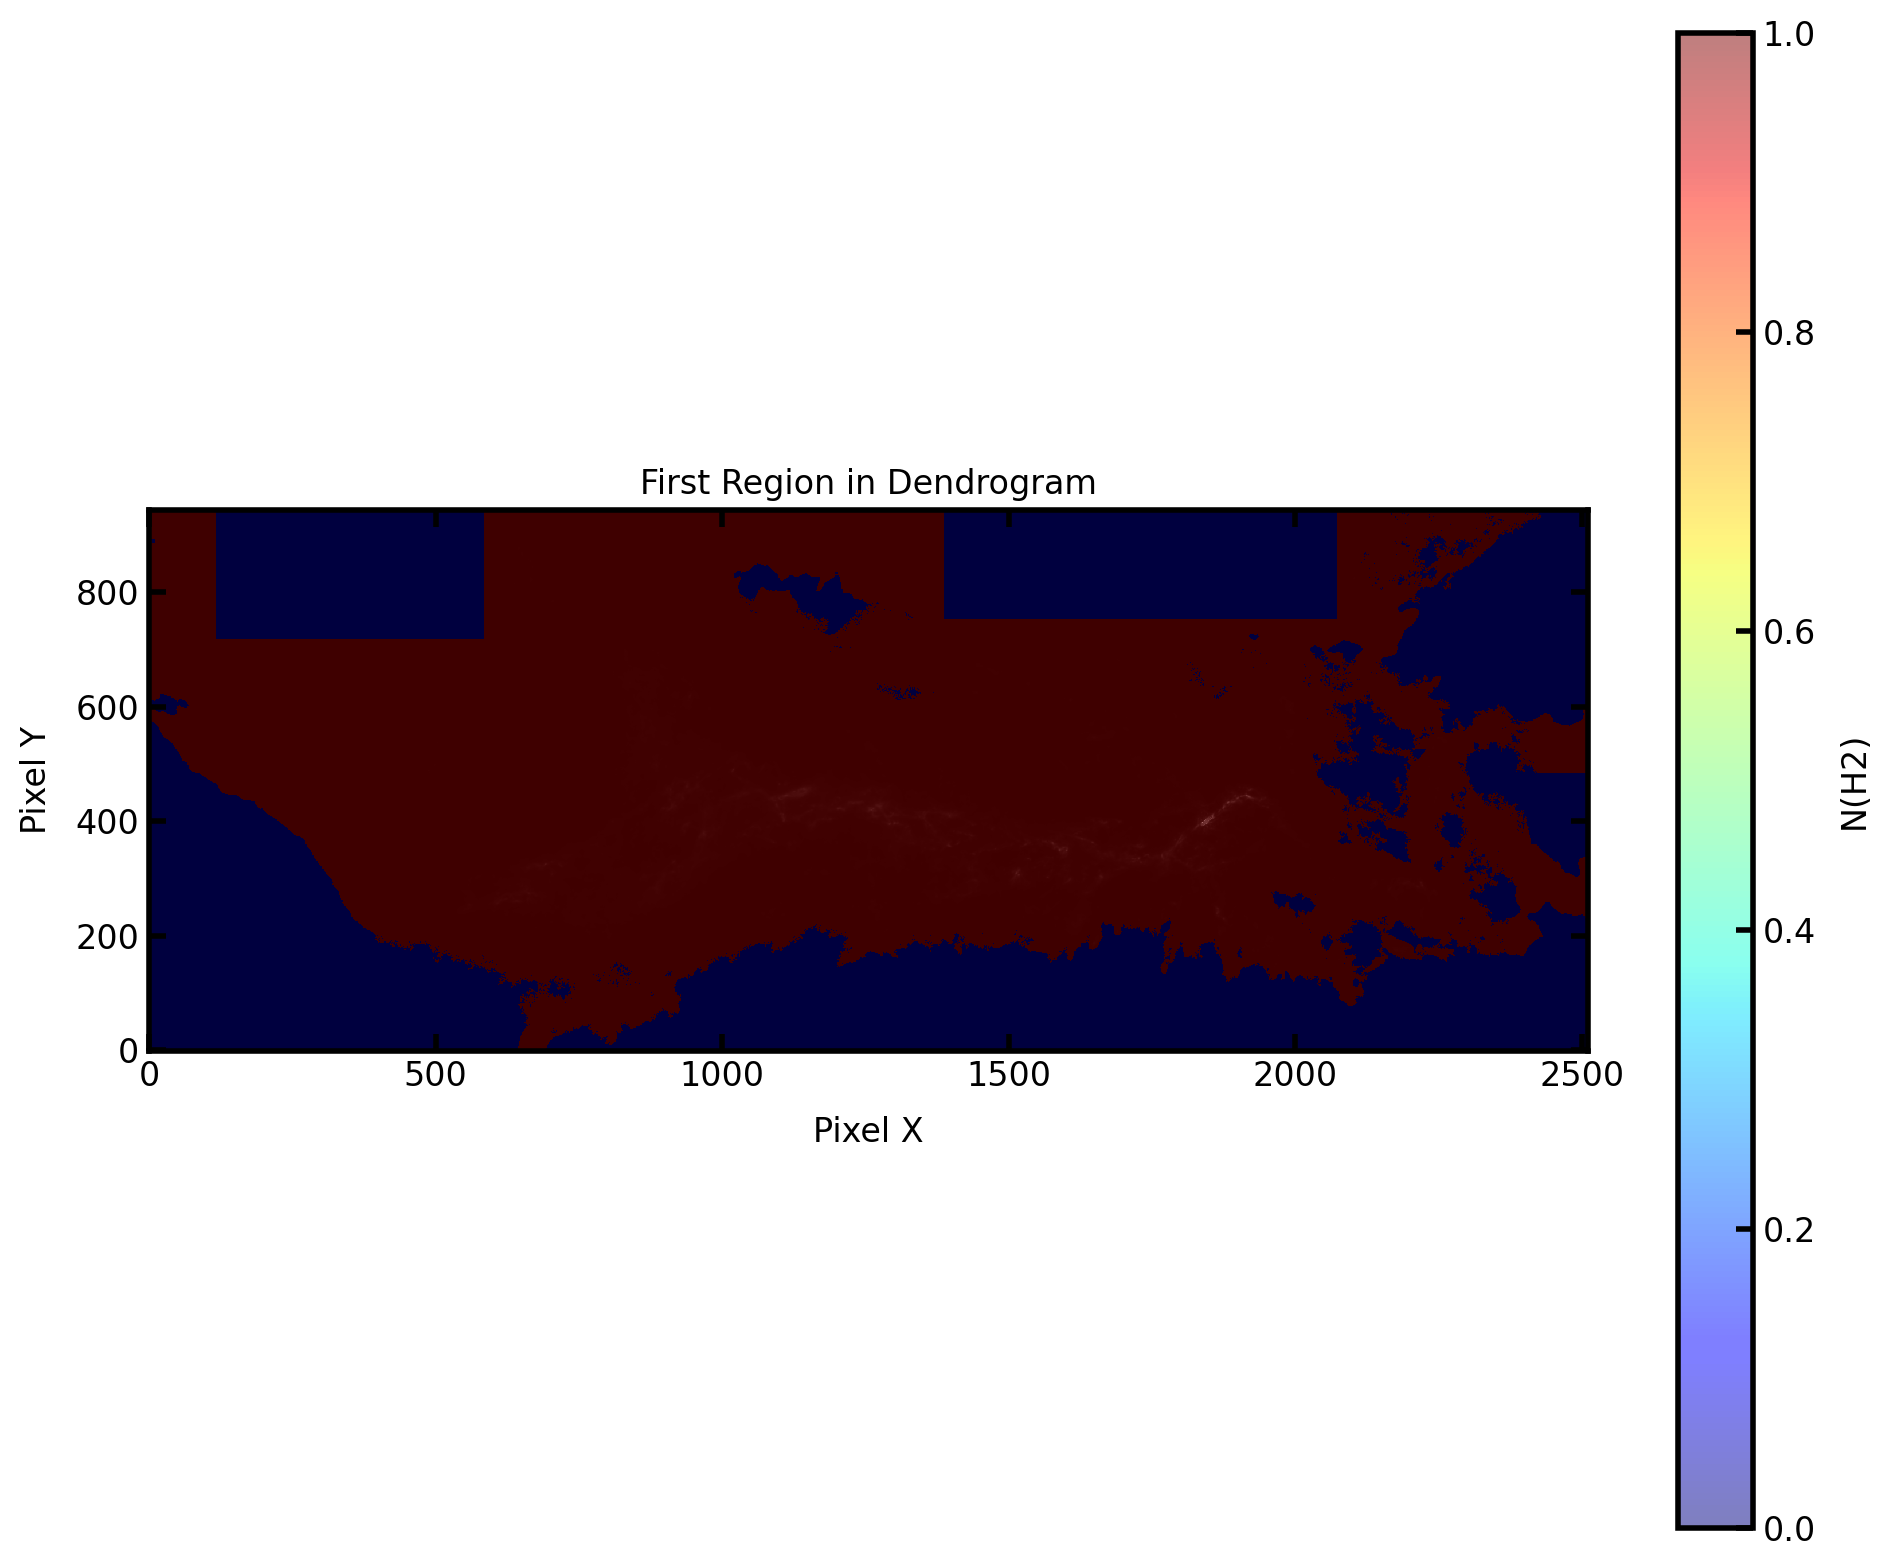

In [ ]:
first_structure = d[7000]
first_region_indices = first_structure.indices()

# Create a mask for the first region
mask = np.zeros_like(N_H2_OA, dtype=bool)
mask[first_region_indices] = True

# Plot the region
plt.figure(figsize=(10, 8))
plt.imshow(N_H2_OA, origin='lower', cmap='gray')
plt.imshow(mask, origin='lower', cmap='jet', alpha=0.5)  # Overlay the region mask
plt.colorbar(label='N(H2)')
plt.title('First Region in Dendrogram')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()


In [ ]:
from skimage.measure import perimeter

# Define the function to calculate fractal dimensions
def minkowski_functionals(data, threshold_min=6e21, threshold_max=2.5e22):
    """
    Calculates the Minkowski functionals for the given data.

    Parameters:
        data (ndarray): 2D array of the map data.
        threshold_min (float): Minimum threshold value.
        threshold_max (float): Maximum threshold value.

    Returns:
        log_areas (ndarray): Log areas.
        log_perimeters (ndarray): Log perimeters.
    """
    thresholds = np.logspace(np.log10(threshold_min), np.log10(threshold_max), 100)

    # Storage for results
    areas = []
    perimeters = []

    # Process each threshold
    for threshold in thresholds:
        # Create binary mask
        mask = data >= threshold

        # Compute Area (v0)
        area = np.sum(mask)
        areas.append(area)

        # Compute Perimeter (v1)
        perim = perimeter(mask)
        perimeters.append(perim)

    # Convert to log scale
    log_areas = np.log10(areas)
    log_perimeters = np.log10(perimeters)

    fractal_dimensions = 2 * log_perimeters / log_areas

    return fractal_dimensions, thresholds

# Step 3: Extract and analyze regions
results = []
for structure in d:
    # Get the indices of pixels belonging to this structure
    region_indices = structure.indices()
    
    # Create a mask for the region
    mask = np.zeros_like(N_H2_OA, dtype=bool)
    mask[region_indices] = True
    
    # Analyze the region
    fractal_dimensions, thresholds = minkowski_functionals(mask)
    
    # Store the results
    results.append({
        'structure_id': structure.idx,
        'fractal_dimensions': fractal_dimensions,
        'thresholds': thresholds,
        'region_size': len(region_indices[0])  # Number of pixels in the region
    })
    # Filter out structures that do not appear within the threshold range

    # Print the filtered results
for res in results:
    plt.plot(thresholds, res['fractal_dimensions'], label=f"Structure {res['structure_id']}")
    print(f"Structure ID: {res['structure_id']}")
    print(f"Fractal Dimensions: {res['fractal_dimensions']}")
    print(f"Thresholds: {res['thresholds']}")
    print(f"Region Size: {res['region_size']}")


plt.xlabel('Threshold')
plt.ylabel('Fractal Dimensions')
plt.title('Fractal Dimensions vs. Threshold for Structures')
plt.show()

KeyboardInterrupt: 

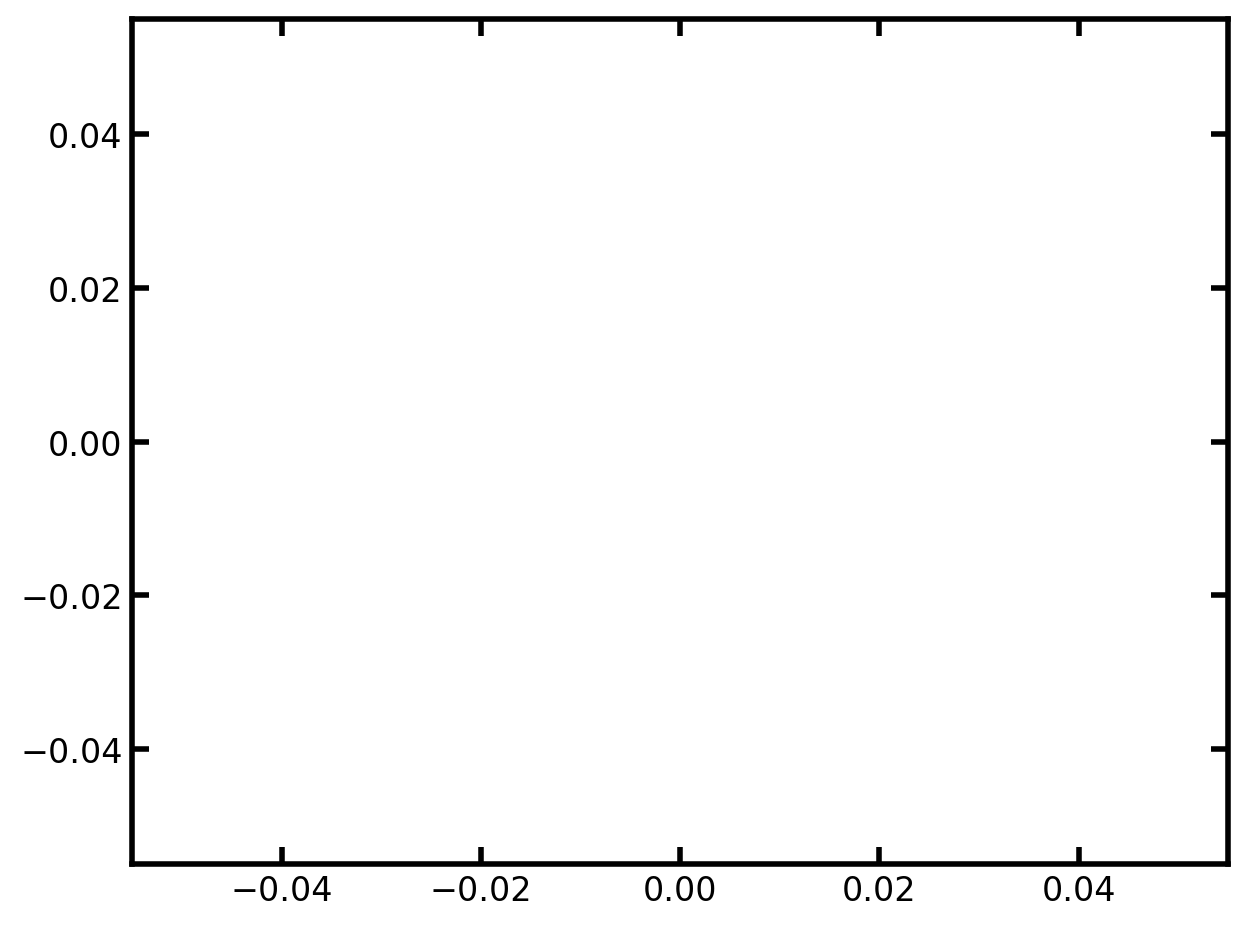

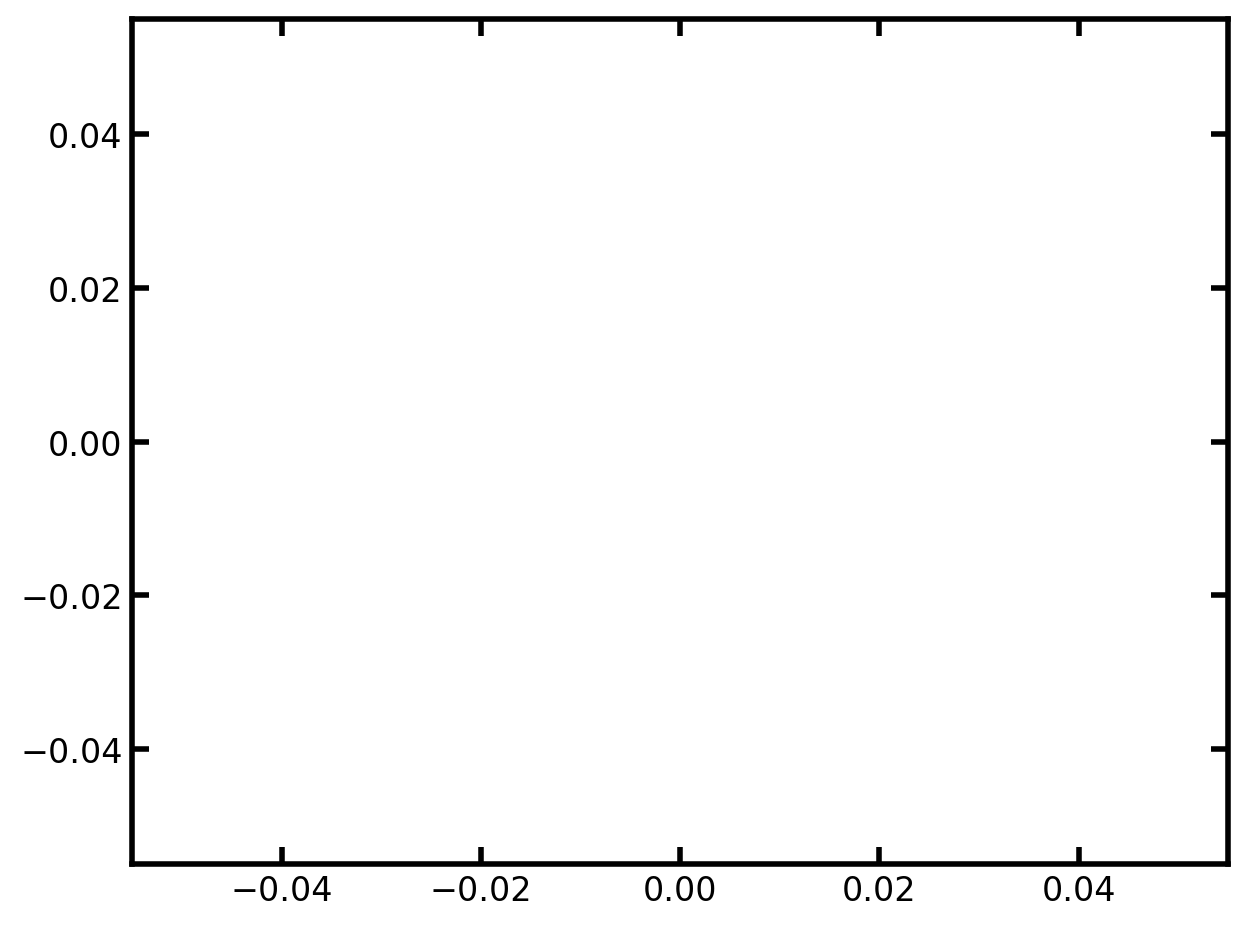

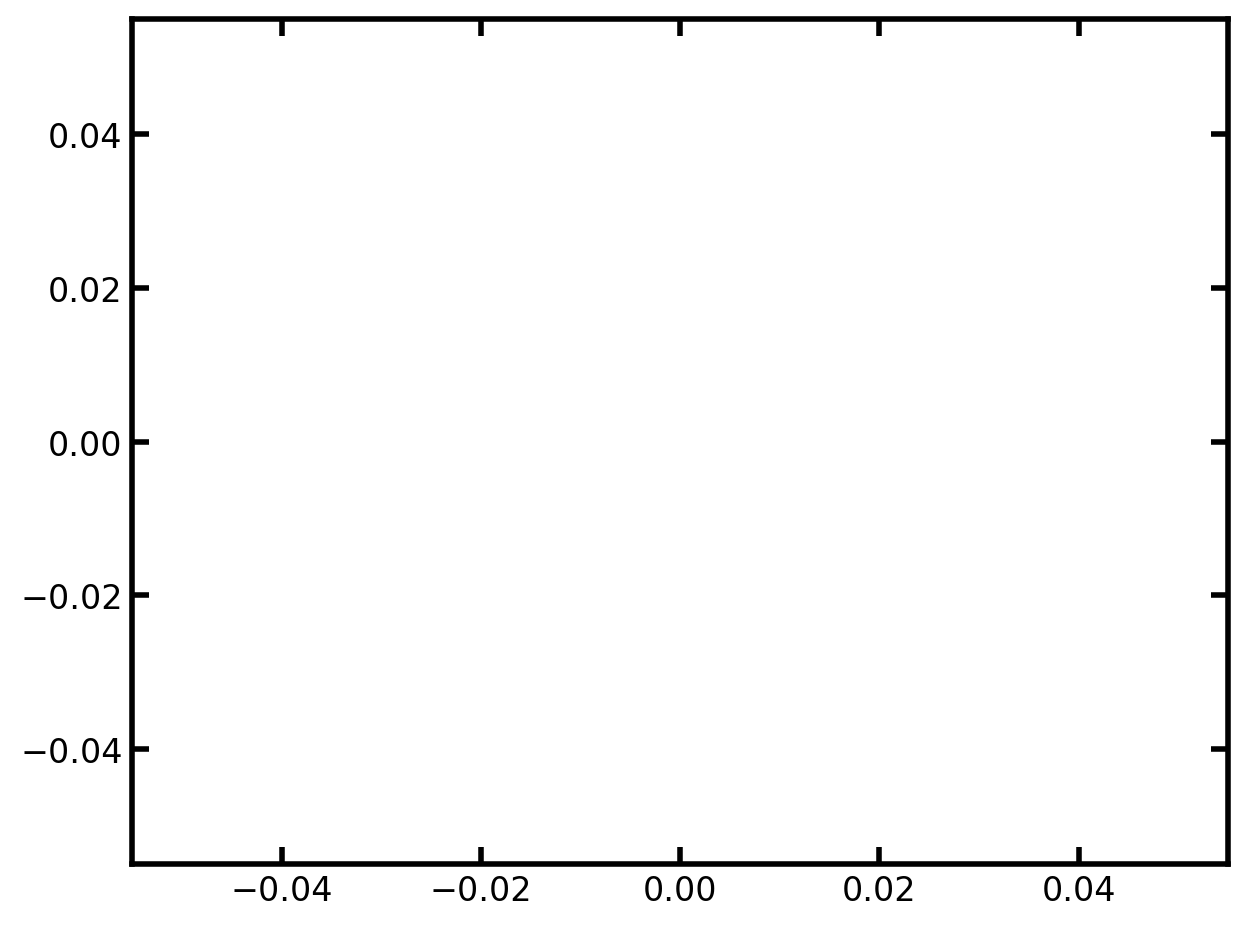

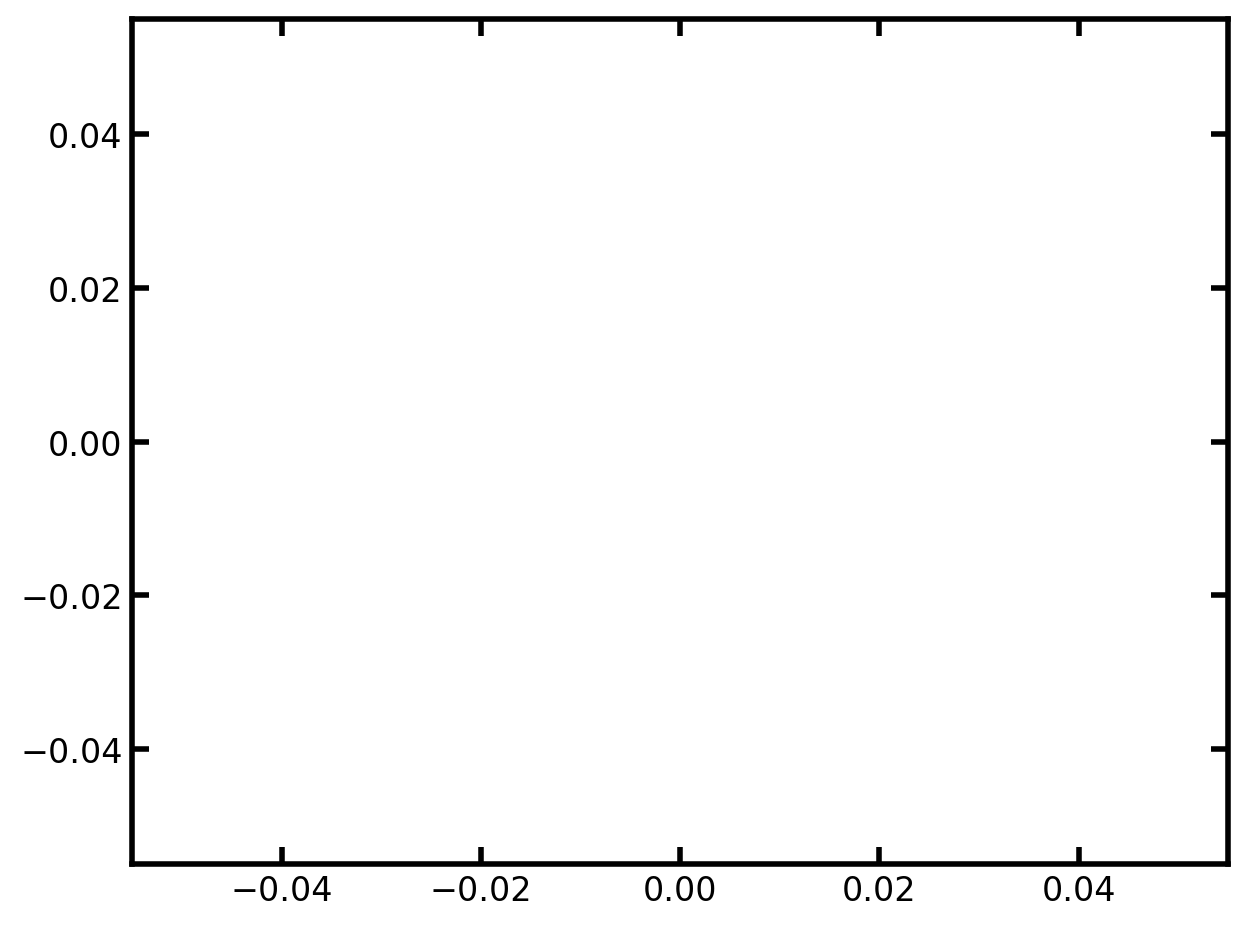

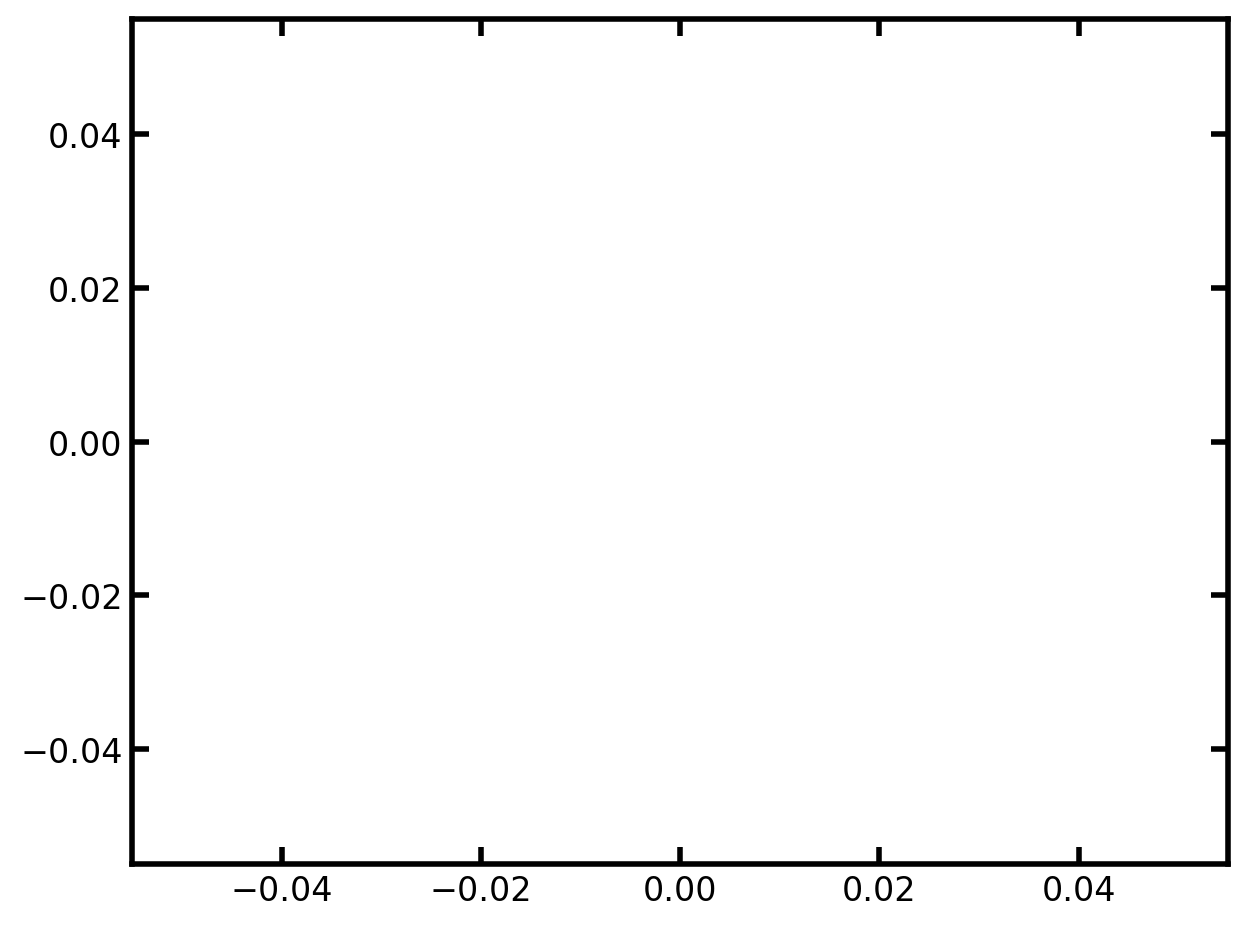

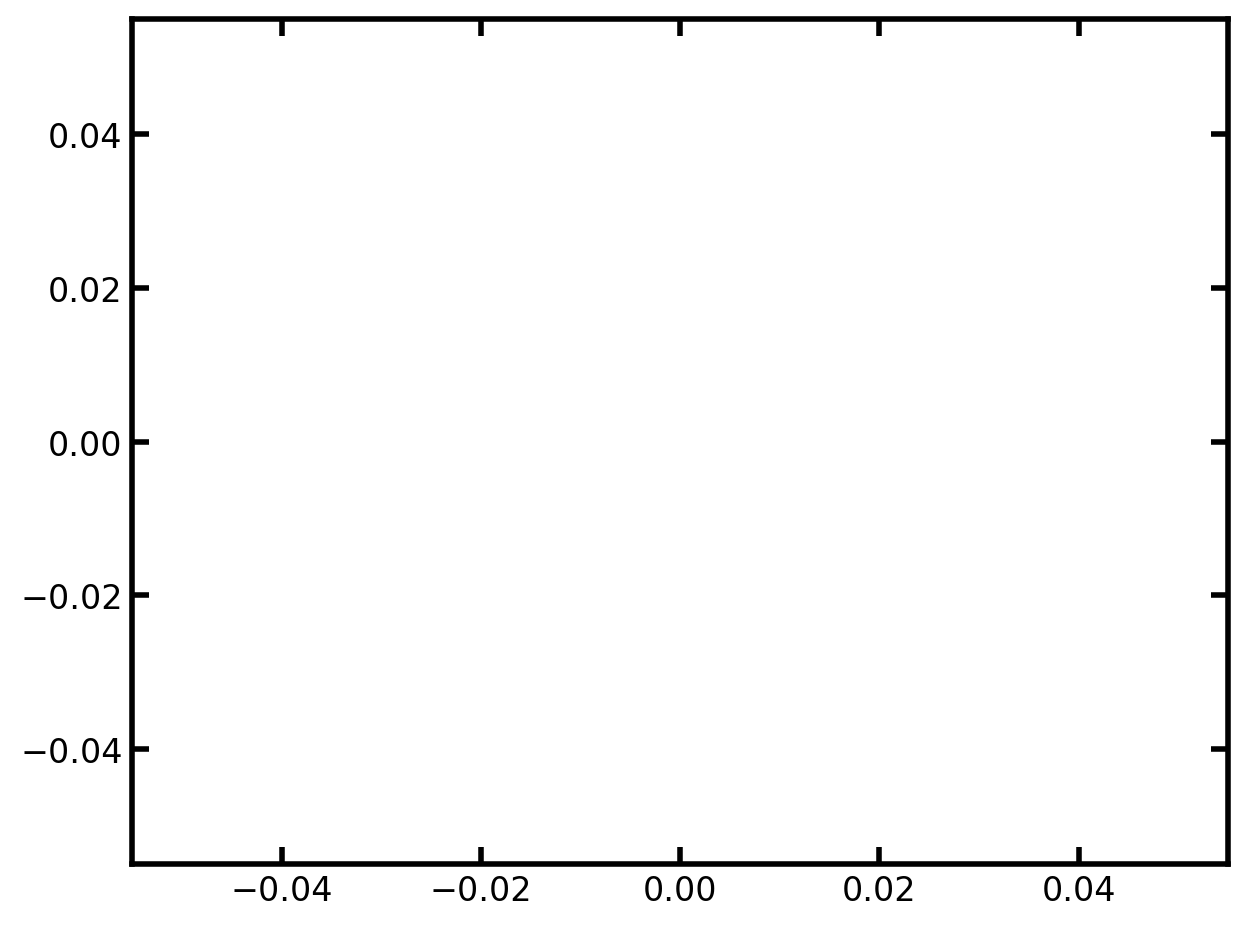

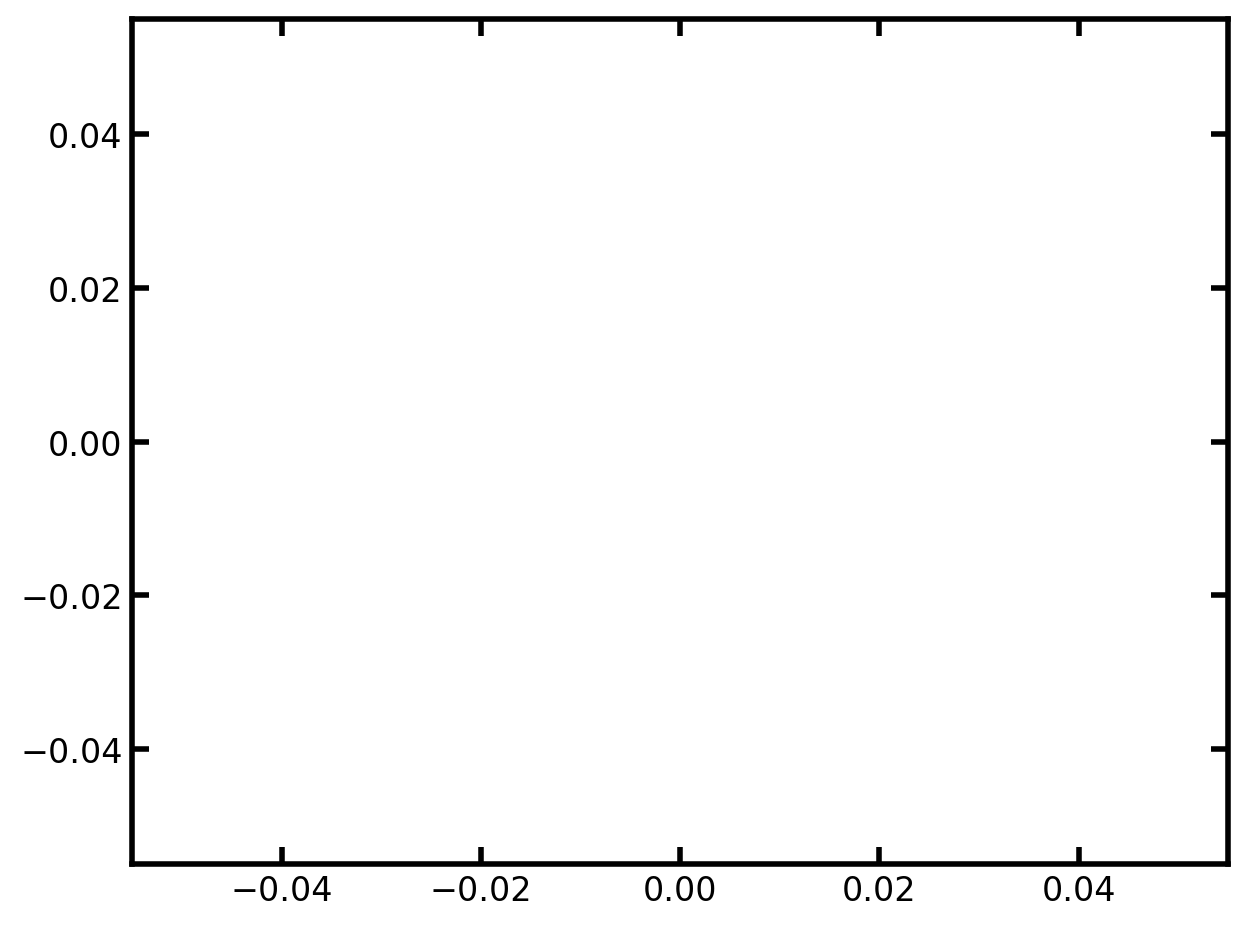

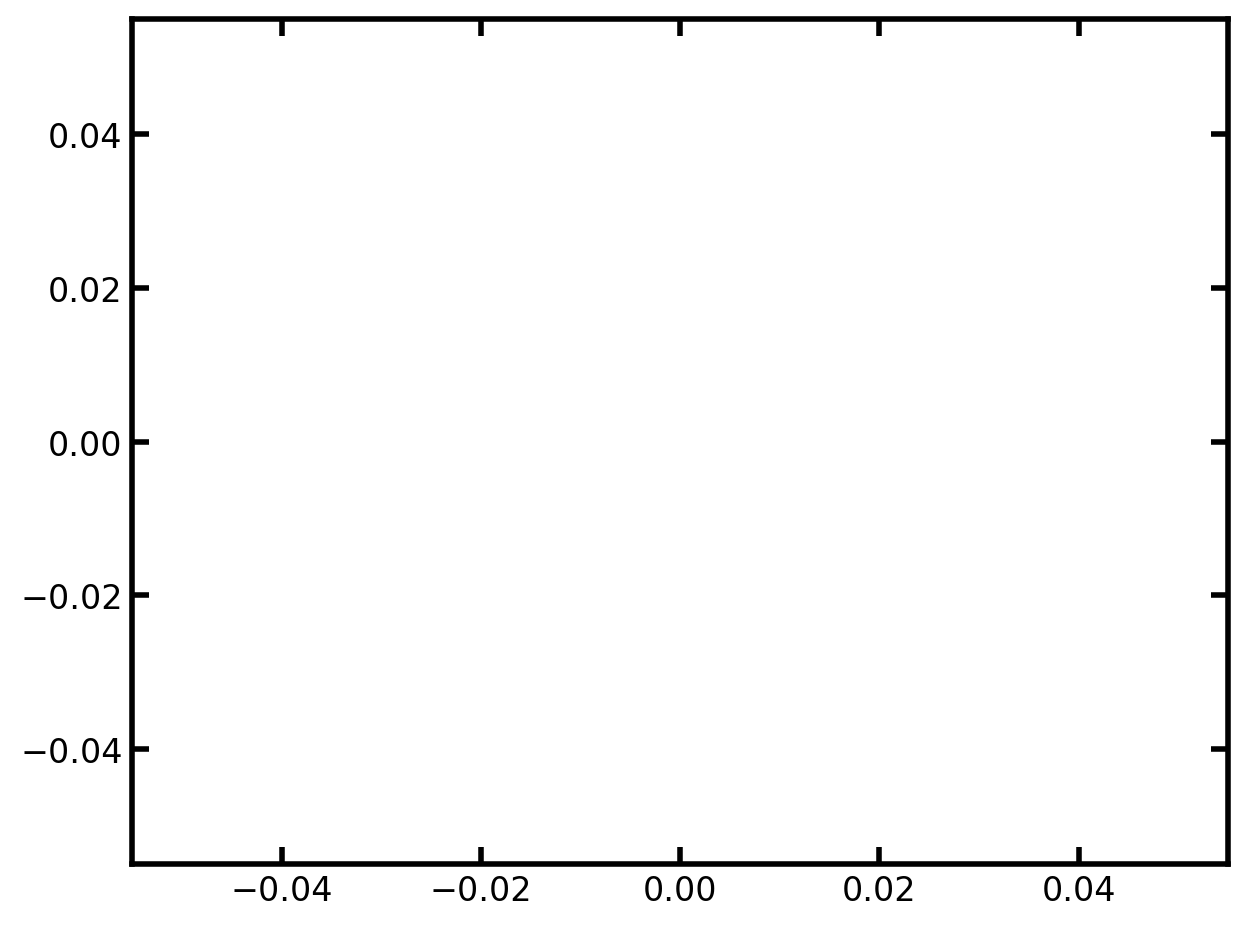

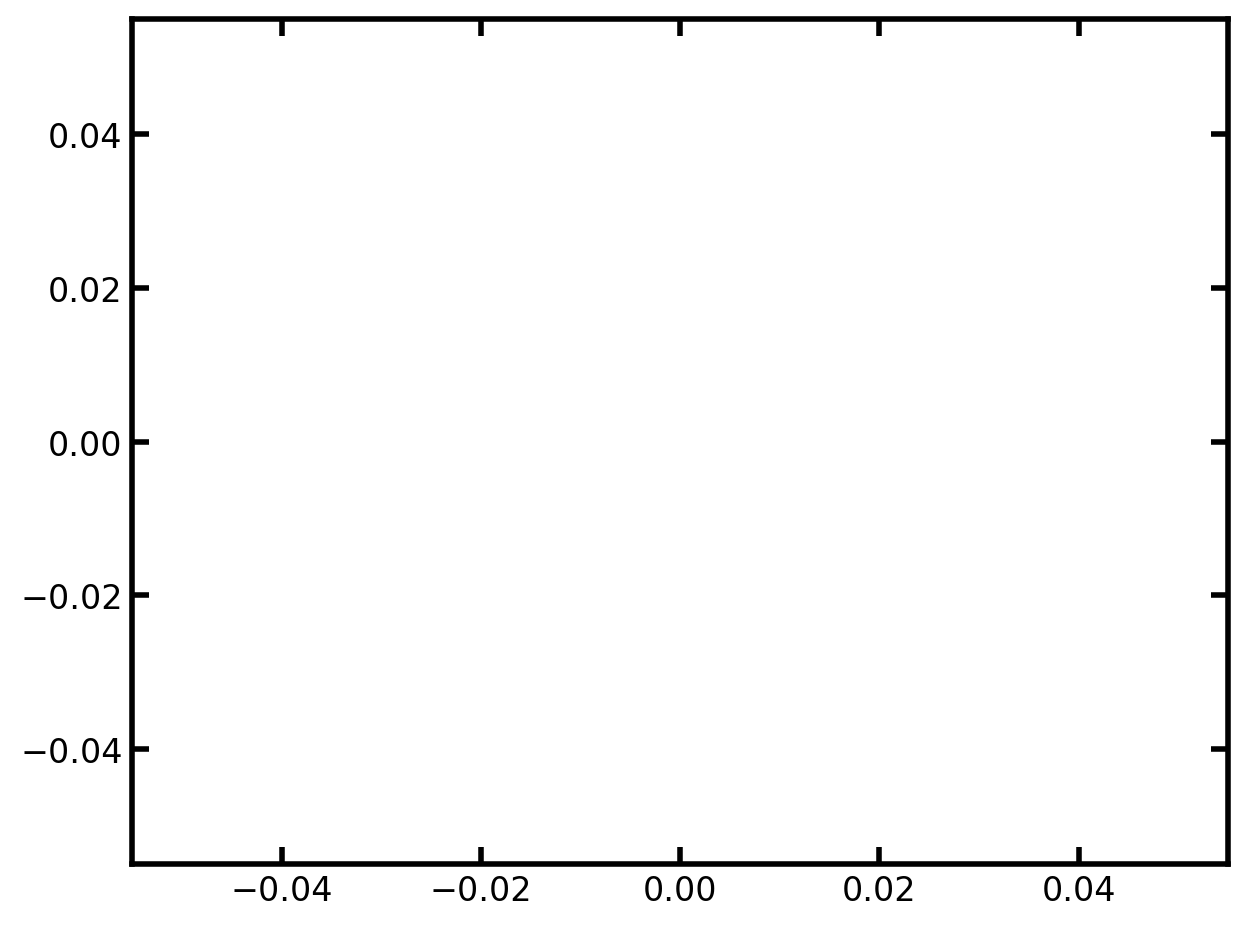

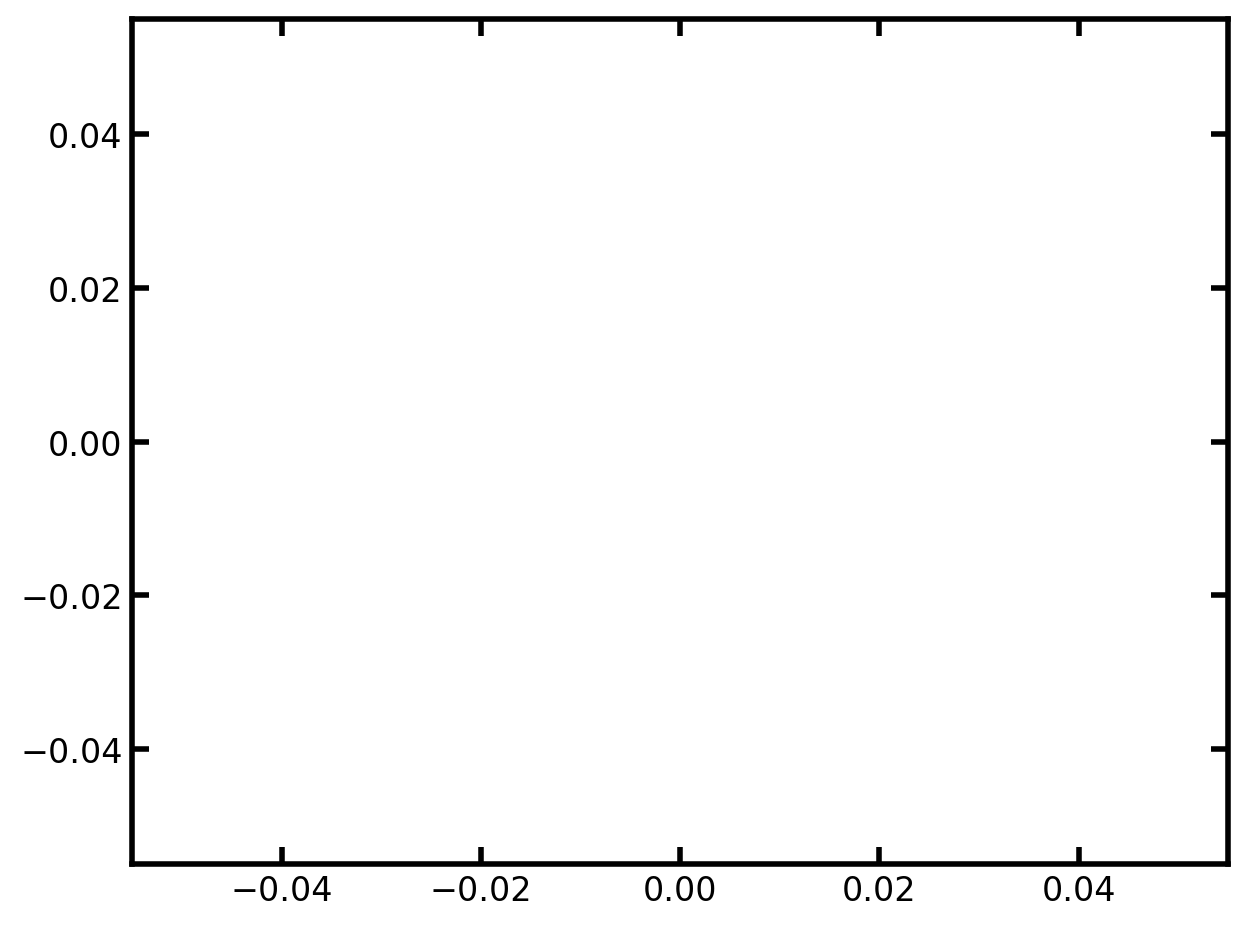

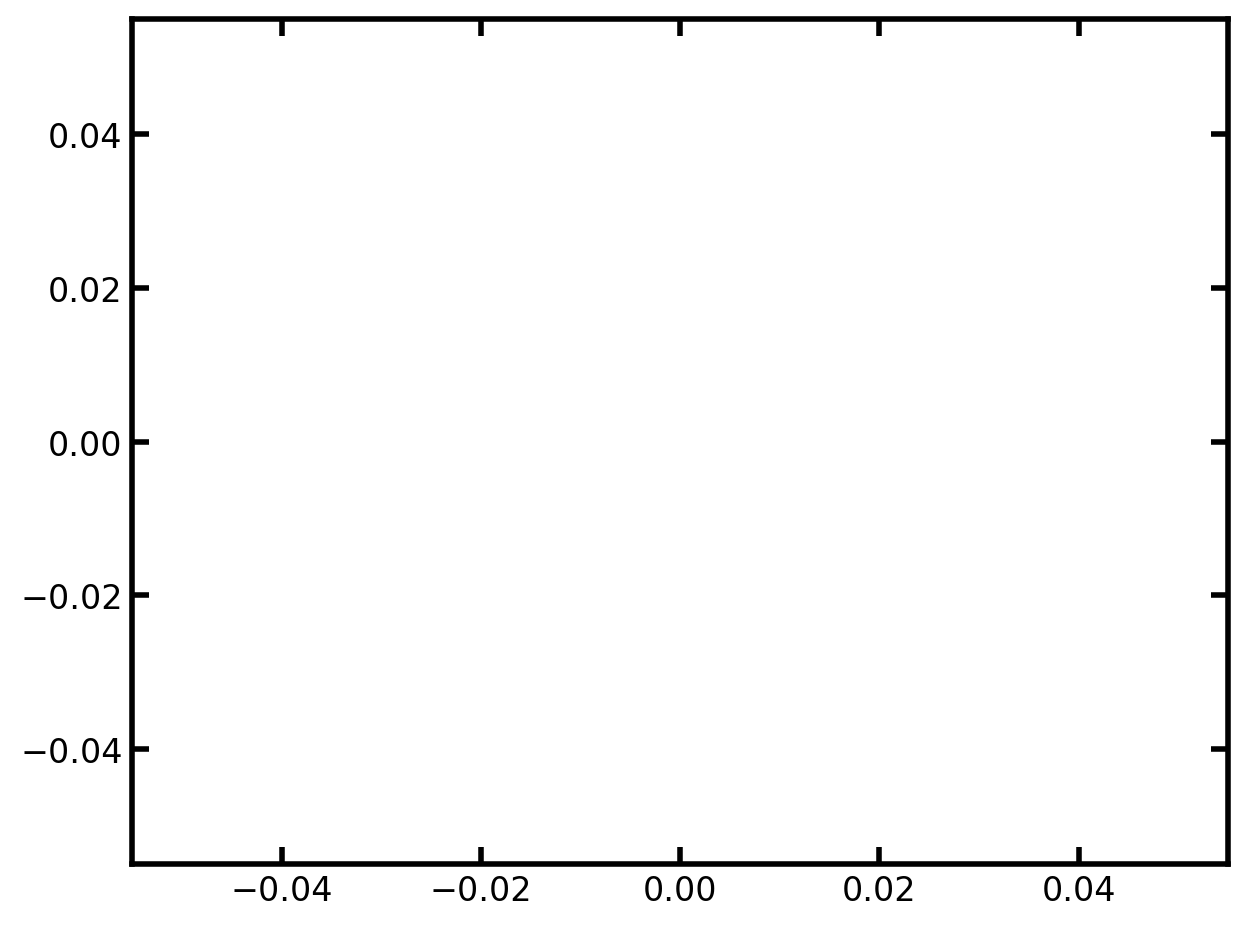

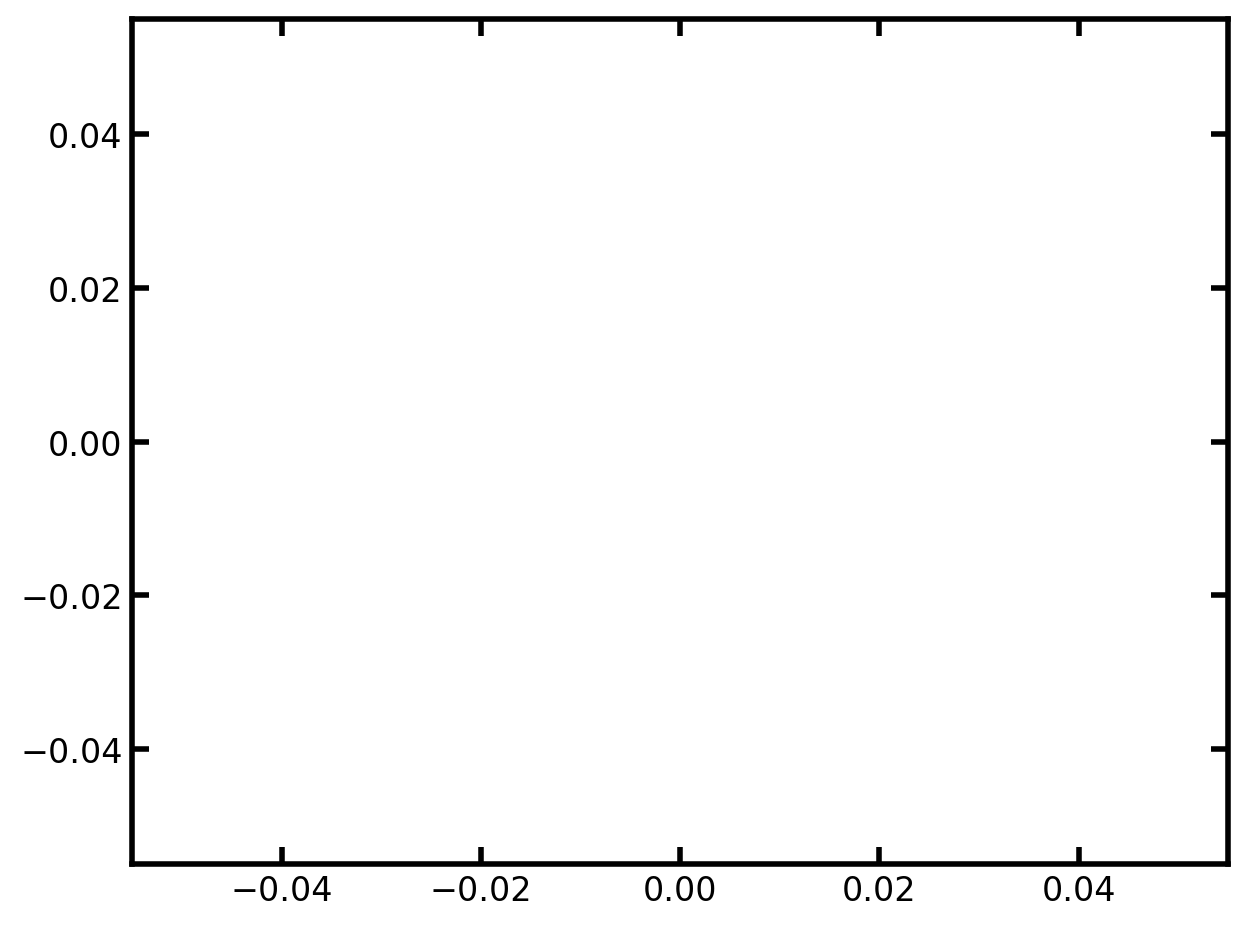

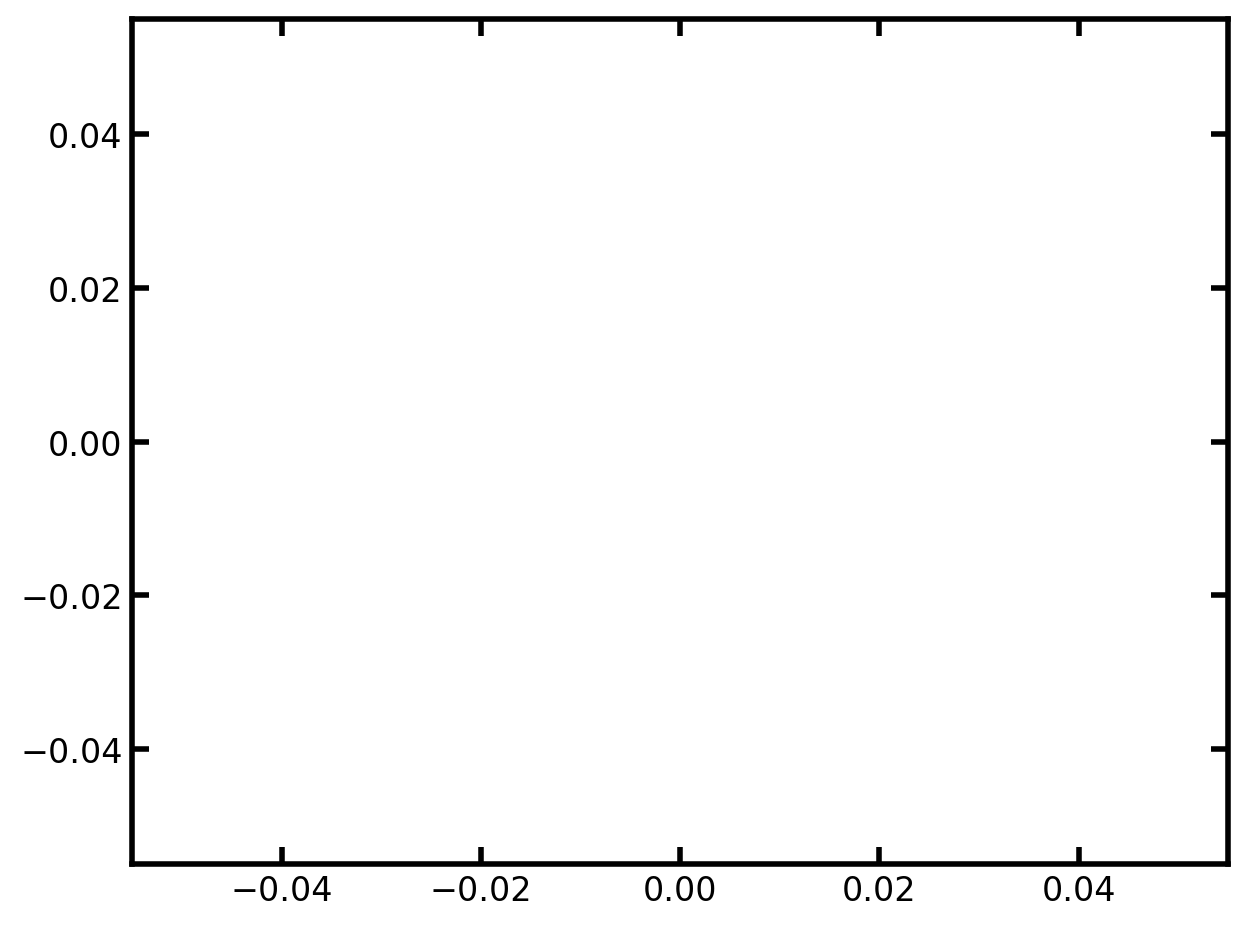

KeyboardInterrupt: 

In [ ]:
for res in results:
    plt.scatter(thresholds, res['fractal_dimensions'])
    plt.show()